In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchinfo import summary

import os
import glob
import time
import datetime as dt
from netCDF4 import Dataset as nc_Dataset
from netCDF4 import date2num, num2date
import pandas as pd
import numpy as np
import math
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.markers import MarkerStyle
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mpl_scatter_density
from mpl_scatter_density import ScatterDensityArtist
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LinearRegression

from FunctionsAndClasses.HRRR_URMA_Datasets_AllVars import *
from FunctionsAndClasses.SR_UNet_simple import *
from FunctionsAndClasses.DefineModelAttributes import *
from FunctionsAndClasses.StatObjectConstructor import *
from FunctionsAndClasses.utils import *

In [2]:
## Change as needed
PREDICTOR_VARS = ["t2m"]
TARGET_VARS = ["t2m"]

TARG_VAR="t2m"

In [3]:
model_1_attrs = DefineModelAttributes(is_train=False)

### Change as needed
model_1_attrs.predictor_vars = PREDICTOR_VARS
model_1_attrs.target_vars = TARGET_VARS

model_1_attrs.create_save_name()
model_1_attrs.create_dataset()

Making dataset for model BS256_NE1000_tD_pred(t2m)_targ(t2m)
Terrain normalization done for ['diff']
Loading predictor dataset for t2m (Year = 2024, months = 1 to 12, hours = all)
Predictor dataset data loaded. Time taken = 1.9 sec
Normalizing over all times
Normalization done. Time taken = 0.5 sec
Loading target dataset for t2m (Year = 2024, months = 1 to 12, hours = all)
Target dataset data loaded. Time taken = 1.9 sec
Normalizing over all times
Normalization done. Time taken = 0.5 sec
DATASET CONSTRUCTION DONE


In [4]:
model_2_attrs = DefineModelAttributes(is_train=False, with_terrains=None)#["hrrr","urma","diff"])

### Change as needed
model_2_attrs.predictor_vars = PREDICTOR_VARS
model_2_attrs.target_vars = TARGET_VARS

model_2_attrs.create_save_name()
# model_2_attrs.savename = f"RMSELoss_{model_2_attrs.savename}"
model_2_attrs.create_dataset()

Making dataset for model BS256_NE1000_pred(t2m)_targ(t2m)
Loading predictor dataset for t2m (Year = 2024, months = 1 to 12, hours = all)
Predictor dataset data loaded. Time taken = 0.3 sec
Normalizing over all times
Normalization done. Time taken = 0.5 sec
Loading target dataset for t2m (Year = 2024, months = 1 to 12, hours = all)
Target dataset data loaded. Time taken = 0.2 sec
Normalizing over all times
Normalization done. Time taken = 0.5 sec
DATASET CONSTRUCTION DONE


In [5]:
model_3_attrs = DefineModelAttributes(is_train=False, with_terrains=["hrrr","urma","diff"])

### Change as needed
model_3_attrs.predictor_vars = PREDICTOR_VARS
model_3_attrs.target_vars = TARGET_VARS

model_3_attrs.create_save_name()
# model_2_attrs.savename = f"RMSELoss_{model_2_attrs.savename}"
model_3_attrs.create_dataset()

Making dataset for model BS256_NE1000_tH_tU_tD_pred(t2m)_targ(t2m)
Terrain normalization done for ['hrrr', 'urma', 'diff']
Loading predictor dataset for t2m (Year = 2024, months = 1 to 12, hours = all)
Predictor dataset data loaded. Time taken = 0.3 sec
Normalizing over all times
Normalization done. Time taken = 0.5 sec
Loading target dataset for t2m (Year = 2024, months = 1 to 12, hours = all)
Target dataset data loaded. Time taken = 0.2 sec
Normalizing over all times
Normalization done. Time taken = 0.5 sec
DATASET CONSTRUCTION DONE


In [6]:
model_1 = SR_UNet_simple(n_channels_in=model_1_attrs.num_channels_in, n_channels_out=model_1_attrs.num_channels_out)
device = torch.device("cuda")
model_1.to(device)
model_1.load_state_dict(torch.load(f"/scratch/RTMA/alex.schein/CNN_Main/Trained_models/MAE_Loss/{model_1_attrs.savename}.pt", weights_only=True))

<All keys matched successfully>

In [7]:
model_2 = SR_UNet_simple(n_channels_in=model_2_attrs.num_channels_in, n_channels_out=model_2_attrs.num_channels_out)
device = torch.device("cuda")
model_2.to(device)
model_2.load_state_dict(torch.load(f"/scratch/RTMA/alex.schein/CNN_Main/Trained_models/MAE_Loss/{model_2_attrs.savename}.pt", weights_only=True))

<All keys matched successfully>

In [8]:
model_3 = SR_UNet_simple(n_channels_in=model_3_attrs.num_channels_in, n_channels_out=model_3_attrs.num_channels_out)
device = torch.device("cuda")
model_3.to(device)
model_3.load_state_dict(torch.load(f"/scratch/RTMA/alex.schein/CNN_Main/Trained_models/MAE_Loss/{model_3_attrs.savename}.pt", weights_only=True))

<All keys matched successfully>

In [9]:
statsobj_smartinit = ConstructStatObject(is_smartinit=True, target_var="t2m")
FORECAST_LEAD_HOURS = 1
START_DATE = dt.datetime(2024,1,1,0)-dt.timedelta(hours=FORECAST_LEAD_HOURS)

In [17]:
model_1_multiple_outputs = np.array([])
model_2_multiple_outputs = np.array([])
model_3_multiple_outputs = np.array([])
model_smartinit_multiple_outputs = np.array([])
targ_multiple_outputs = np.array([])
for IDX in range(500):
    IDX=IDX*17
    _, targ, model_1_output, _ = get_model_output_at_idx(model_attrs=model_1_attrs, model=model_1, idx=IDX, pred_var=TARG_VAR, targ_var=TARG_VAR)
    _, _, model_2_output, _ = get_model_output_at_idx(model_attrs=model_2_attrs, model=model_2, idx=IDX, pred_var=TARG_VAR, targ_var=TARG_VAR)
    _, _, model_3_output, _ = get_model_output_at_idx(model_attrs=model_3_attrs, model=model_3, idx=IDX, pred_var=TARG_VAR, targ_var=TARG_VAR)
    smartinit_output = get_smartinit_output_at_idx(IDX, 
                                                START_DATE, 
                                                FORECAST_LEAD_HOURS, 
                                                statsobj_smartinit.smartinit_var_select_dict, 
                                                statsobj_smartinit.varname_translation_dict, 
                                                statsobj_smartinit.target_var)
    model_1_multiple_outputs = np.concatenate((model_1_multiple_outputs, model_1_output.flatten()))
    model_2_multiple_outputs = np.concatenate((model_2_multiple_outputs, model_2_output.flatten()))
    model_3_multiple_outputs = np.concatenate((model_3_multiple_outputs, model_3_output.flatten()))
    model_smartinit_multiple_outputs = np.concatenate((model_smartinit_multiple_outputs, smartinit_output.data.flatten()))
    targ_multiple_outputs = np.concatenate((targ_multiple_outputs, targ.flatten()))
    # model_2_multiple_outputs.append(model_2_output.flatten())
    # targ_multiple_outputs.append(targ.flatten())

Ignoring index file '/data1/projects/RTMA/alex.schein/HRRR_Smartinit_Data/hrrr_smartinit_20240211_t18z_f01.grib2.da267.idx' incompatible with GRIB file


In [18]:
def plot_scatter_for_one_model(x,y,model_savename):
    # "Viridis-like" colormap with white background
    white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
        (0, '#ffffff'),
        (1e-20, '#440053'),
        (0.2, '#404388'),
        (0.4, '#2a788e'),
        (0.6, '#21a784'),
        (0.8, '#78d151'),
        (1, '#fde624'),
    ], N=256)

    model_linreg = LinearRegression()
    model_linreg.fit(x.reshape(-1,1), y)
    slope = (model_linreg.coef_)[0]
    intercept = model_linreg.intercept_
    r2_score = model_linreg.score(x.reshape(-1,1), y)

    xseq = np.linspace(np.min(x),np.max(x), len(x))
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    bestfit = ax.plot(xseq, (slope*xseq + intercept), '--r')
    plt.title(f"{model_savename}, r2 = {r2_score:.3f}")
    plt.xlabel(f"Model {TARG_VAR} (deg C)")
    plt.ylabel(f"Target {TARG_VAR} (deg C)")

    return

/home/alex.schein/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/alex.schein/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/home/alex.schein/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/alex.schein/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/home/alex.schein/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/alex.schein/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artis

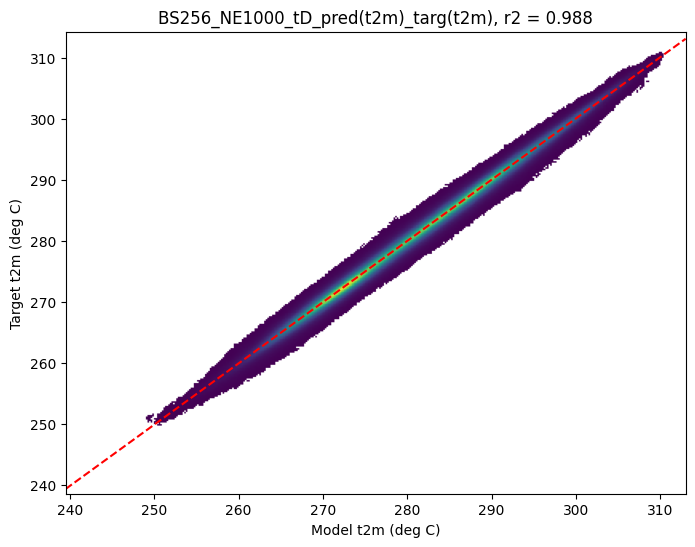

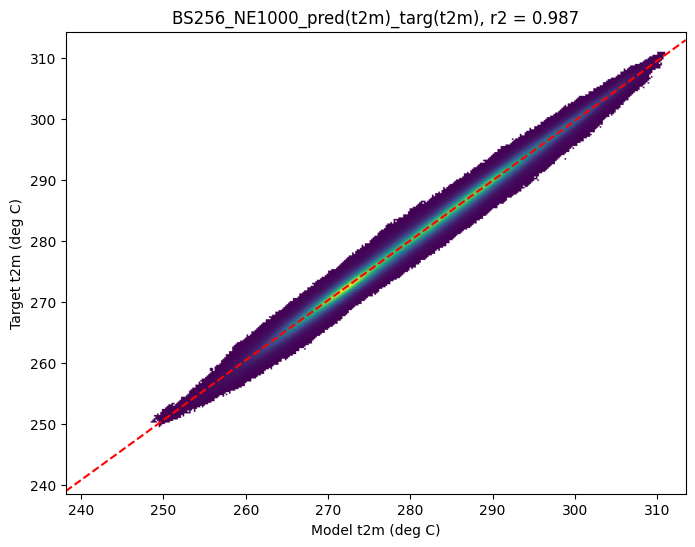

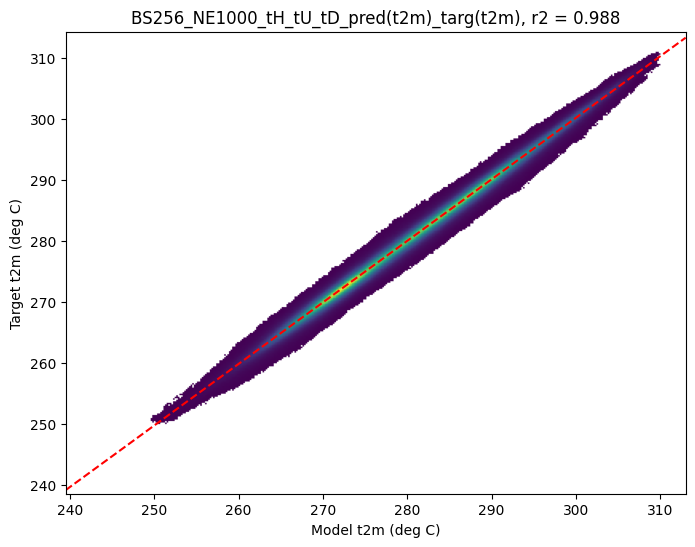

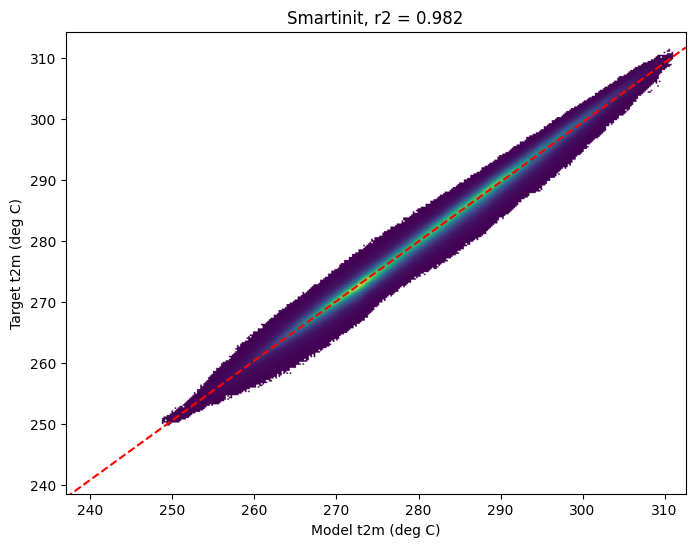

In [19]:
plot_scatter_for_one_model(model_1_multiple_outputs, targ_multiple_outputs, model_1_attrs.savename)
plot_scatter_for_one_model(model_2_multiple_outputs, targ_multiple_outputs, model_2_attrs.savename)
plot_scatter_for_one_model(model_3_multiple_outputs, targ_multiple_outputs, model_3_attrs.savename)
plot_scatter_for_one_model(model_smartinit_multiple_outputs, targ_multiple_outputs, "Smartinit")